# Описание проекта

Стартап разрабатывает мобильное приложение по продаже продуктов питания. Дизайнеры захотели поменть шрифт во всем приложении, но менеджеры сомневаются, понравится ли это пользователям. В целях принятия решения был проведен А/Б тест. Пользователей разбили на 3 группы: 2 контрольные со старыми шрифтами и одну экспериментальную — с новыми. В распоряжении есть данные о результатах теста:
- `EventName` — название события;
- `DeviceIDHash` — уникальный идентификатор пользователя;
- `EventTimestamp` — время события;
- `ExpId` — номер эксперимента: 246 и 247 — контрольные группы, а 248 — экспериментальная

**Цель исследования:** изучить воронку продаж и определить, какой шрифт лучше.

Содержание:
1. [Изучение данных из файлов](#first)
2. [Подготовка данных](#second)
3. [Изучение и проверка данных](#third)
4. [Изучение воронки событий](#fourth)
5. [Анализ результатов A/B теста](#fifth)
6. [Итоговый вывод](#sixth)

## Изучение данных из файлов 
<a id="first"></a>

In [1]:
%config InlineBackend.figure_format='retina'

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import math as mth
from scipy import stats

In [2]:
data = pd.read_csv('logs_exp.csv', sep='\t')

In [3]:
data.head()

,EventName,DeviceIDHash,EventTimestamp,ExpId
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   EventName       244126 non-null  object
 1   DeviceIDHash    244126 non-null  int64 
 2   EventTimestamp  244126 non-null  int64 
 3   ExpId           244126 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 7.5+ MB


**Вывод:** пропуски отсутствуют, колонку EventTimestamp следует привести к типу данных datetime.

## Подготовка данных
<a id="second"></a>

In [5]:
data = data.rename(columns={'EventName':'event',
                            'DeviceIDHash':'user_id',
                            'EventTimestamp':'event_time',
                            'ExpId':'group'})
data.head()

,event,user_id,event_time,group
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248


In [6]:
# перевод формата unix time
data['event_time'] = pd.to_datetime(data['event_time'], unit='s')
data.head()

,event,user_id,event_time,group
0,MainScreenAppear,4575588528974610257,2019-07-25 04:43:36,246
1,MainScreenAppear,7416695313311560658,2019-07-25 11:11:42,246
2,PaymentScreenSuccessful,3518123091307005509,2019-07-25 11:28:47,248
3,CartScreenAppear,3518123091307005509,2019-07-25 11:28:47,248
4,PaymentScreenSuccessful,6217807653094995999,2019-07-25 11:48:42,248


In [7]:
data.duplicated().sum()

413

In [8]:
# удаляем дубликаты
data = data.drop_duplicates().reset_index(drop=True)
# добавляем колонку с датой
data['event_date'] = data['event_time'].dt.date

## Изучение и проверка данных
<a id="third"></a>

In [9]:
data['event'].value_counts()

MainScreenAppear           119101
OffersScreenAppear          46808
CartScreenAppear            42668
PaymentScreenSuccessful     34118
Tutorial                     1018
Name: event, dtype: int64

Всего в логе 5 видов событий.

In [10]:
data['user_id'].nunique()

7551

В данных содержится 7551 пользователь.

In [11]:
data.groupby('user_id')['event'].count().mean()

32.27559263673685

На одного пользователя в среднем приходится 32 события.

In [12]:
print(data['event_date'].min()) # начальная дата в логе
print(data['event_date'].max()) # конечная дата в логе

2019-07-25
2019-08-07


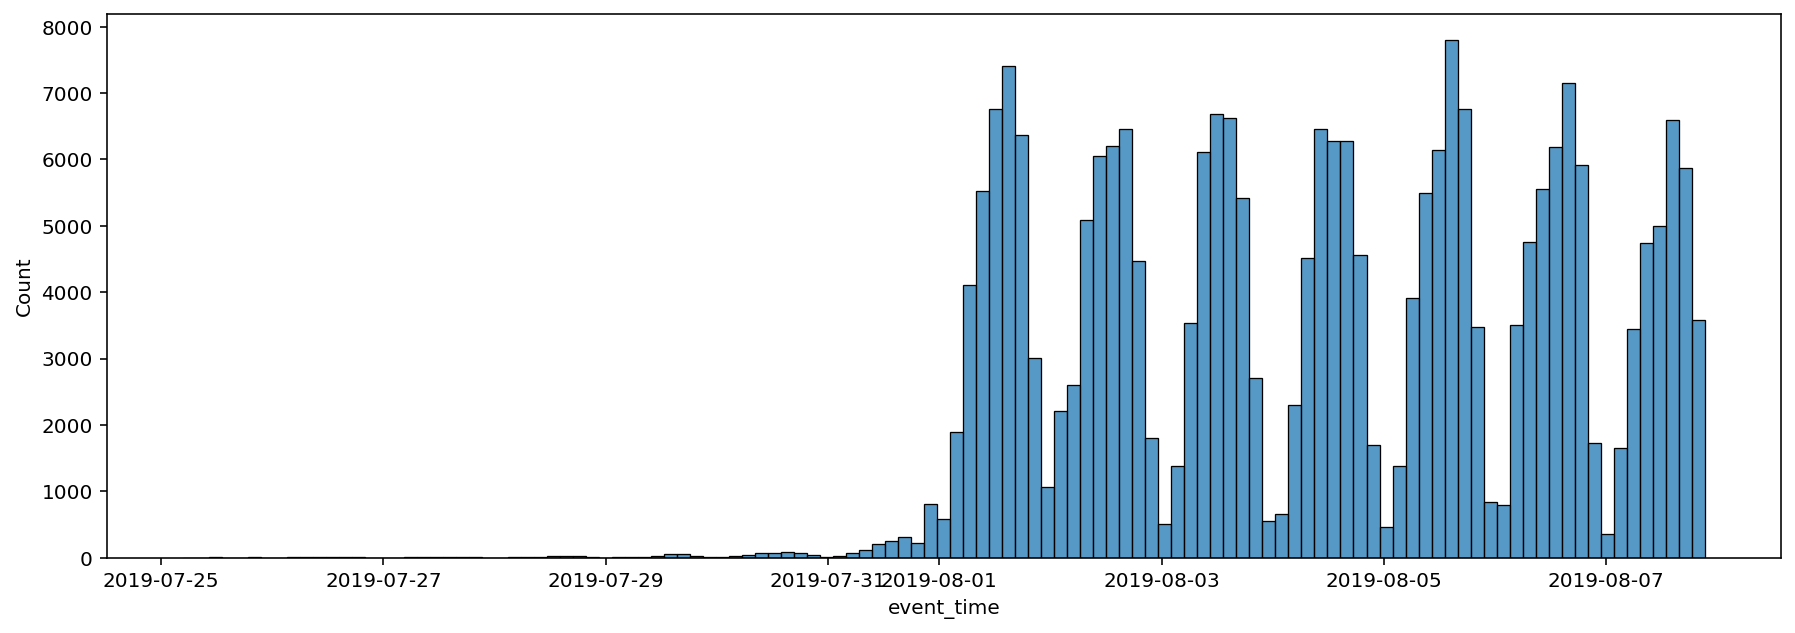

In [13]:
# строим распределение кол-ва пользователей по времени и дате
plt.figure(figsize=(15,5))
sns.histplot(x='event_time', data=data)
plt.show()

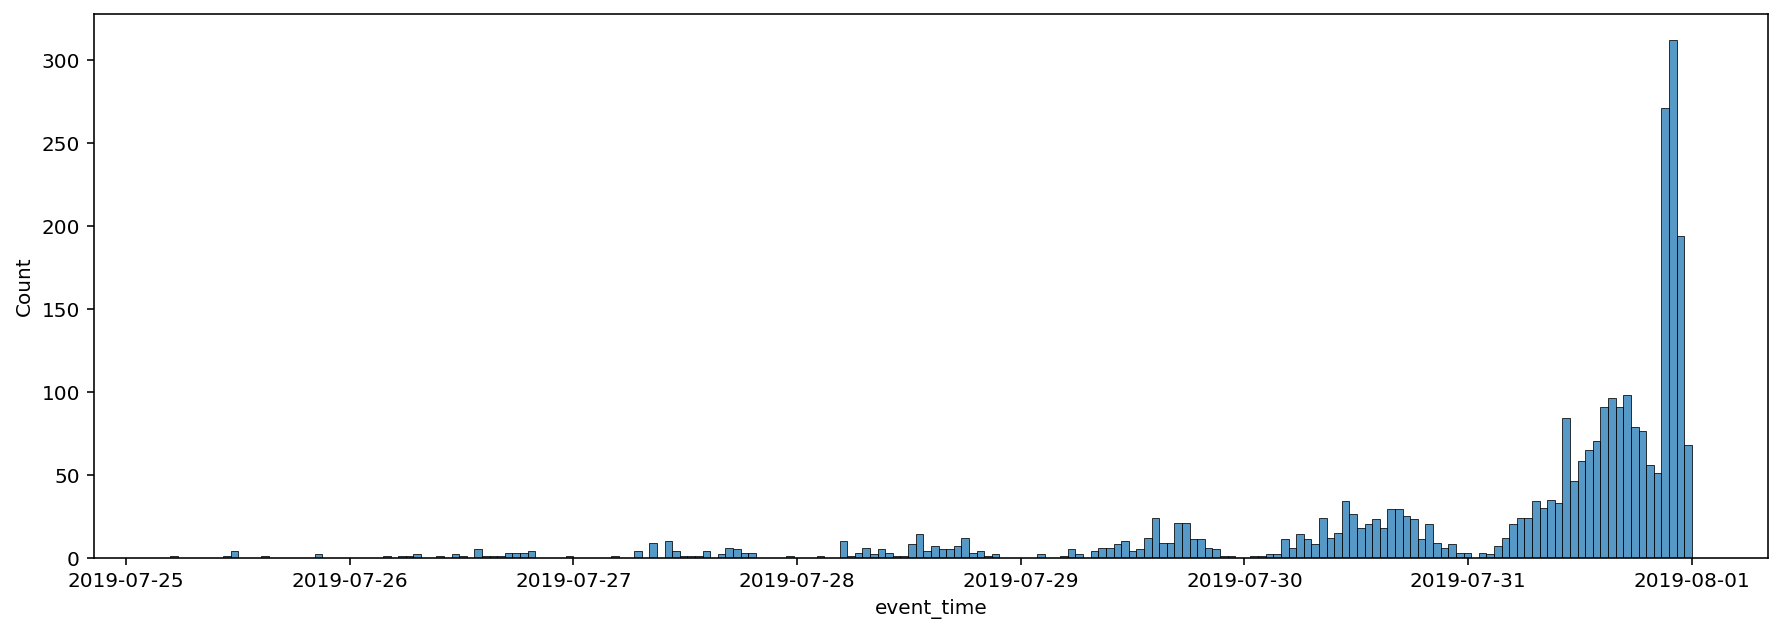

In [14]:
plt.figure(figsize=(15,5))
sns.histplot(x='event_time', data=data.query('event_time < "2019-08-01"'), bins=200)
plt.show()

Как видим, кол-во пользователей до 2019-08-01 незначительное.

In [15]:
# кол-во уникальных пользователей до 2019-08-01
data.query('event_time < "2019-08-01"')['user_id'].nunique()

1451

In [16]:
# кол-во событий до 2019-08-01
data.query('event_time < "2019-08-01"').shape[0]

2826

По гистограммам видно, что до 2019-08-01 событий почти не было из-за малого кол-ва пользователей. Активность постепенно увеличивалась. Целесообразно отбросить этот временной период и начать анализировать с 2019-08-01. При этом начать лучше не 0 часов, а ближе к утру (c 3 часов), чтобы "не доехали" пользователи, которые начали что-то делать поздно вечером предыдущего дня и закончили после полуночи.<br>
**В целях дальнейшего анализа выберем временной интервал с 2019-08-01 03:00:00.**

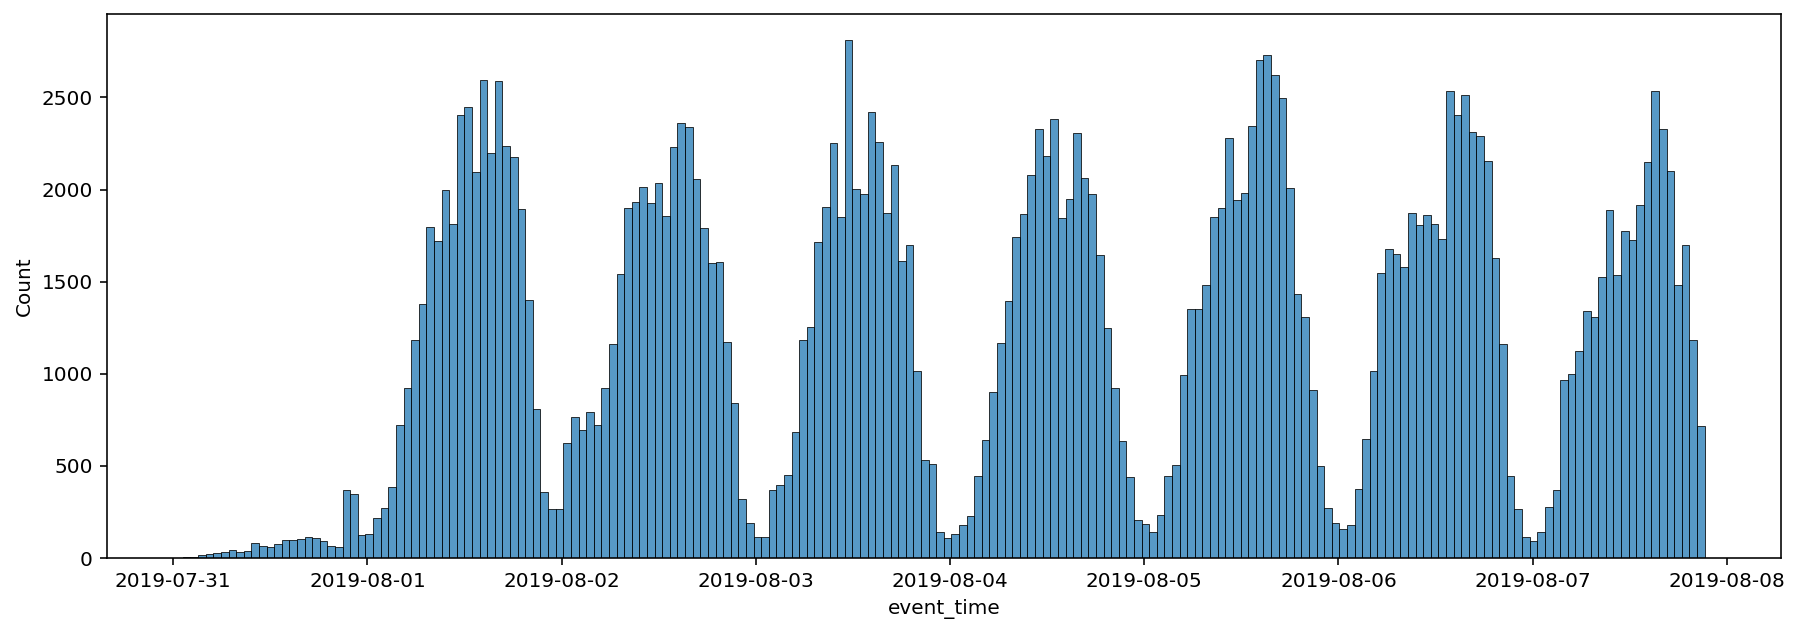

In [17]:
plt.figure(figsize=(15,5))
sns.histplot(x='event_time', data=data.query('event_time > "2019-07-31"'), bins=200)
plt.show()

Отметим, что наибольшая активность приходится на середину дня и послеобеденное время.

In [18]:
# кол-во событий до 2019-08-01 04:00:00
print(data.query('event_time < "2019-08-01 03:00:00"').shape[0])
print(data.query('event_time < "2019-08-01 03:00:00"').shape[0] / data.shape[0] * 100)

3574
1.4664790142503683


Потеряем 3574 событий (1.47%)

In [19]:
# кол-во уникальных пользователей до 2019-08-01 04:00:00
x = data['user_id'].nunique() - data.query('event_time >= "2019-08-01 03:00:00"')['user_id'].nunique()
print(x)
print(x / data.shape[0] * 100)

21
0.008616692585130871


Потеряем 21 пользователя (0.009%)

In [20]:
data_filtered = data.query('event_time >= "2019-08-01 03:00:00"')

In [21]:
data_filtered.groupby('group').agg({'user_id':'nunique'})

,user_id
group,
246,2482
247,2512
248,2536


В данных содержатся пользователи из всех трех экспериментальных групп.

## Изучение воронки событий
<a id="fourth"></a>

In [22]:
data_filtered['event'].value_counts()

MainScreenAppear           116856
OffersScreenAppear          46176
CartScreenAppear            42242
PaymentScreenSuccessful     33864
Tutorial                     1001
Name: event, dtype: int64

Всего 5 видов событий. Раздел с обучением не популярен среди пользователей.

In [23]:
# считаем кол-во уникальных пользователей
temp_1 = data_filtered.groupby('event').agg({'user_id':'nunique'}).sort_values('user_id', ascending=False)

# считаем доли от общего числа уникальных пользователей
temp_2 = temp_1.apply(lambda x: x/data_filtered['user_id'].nunique()*100)

# объединяем в один датафрейм
pd.merge(temp_1, temp_2, left_index=True, right_index=True) \
.rename(columns={'user_id_x':'Уникальные пользователи', 'user_id_y':'Доля от общего числа пользователей, %'})

,Уникальные пользователи,"Доля от общего числа пользователей, %"
event,,
MainScreenAppear,7415,98.472776
OffersScreenAppear,4586,60.903054
CartScreenAppear,3732,49.561753
PaymentScreenSuccessful,3537,46.972112
Tutorial,837,11.115538


Вероятно, продуктовая воронка выглядит следующим образом: Показ главной страницы (MainScreenAppear) - Показ страницы со спецпредложением (OffersScreenAppear) - Страница с корзиной (CartScreenAppear) - Успешная оплата товара (PaymentScreenSuccessful). Через все шаги проходить необязательно (конверсия на первом шаге меньше 100%). Страница с обучением вряд ли будет появлятся после оплаты товара. Скорее всего, это отдельный раздел, в который пользователи заходят по желанию в самом начале или на любом этапе оформления товара. Судя по незначительной доле, данный раздел не пользуется популярностью.

Проверим, согласуются ли данные разных групп между собой.

In [24]:
data_filtered.groupby(['event', 'group']).agg({'user_id':'nunique'}).sort_values('user_id', ascending=False)

user_id
event                   group         
MainScreenAppear        248       2492
                        247       2475
                        246       2448
OffersScreenAppear      246       1538
                        248       1530
                        247       1518
CartScreenAppear        246       1266
                        247       1237
                        248       1229
PaymentScreenSuccessful 246       1200
                        248       1180
                        247       1157
Tutorial                247        282
                        248        279
                        246        276

Данные согласуются - количество пользователей в группах не сильно отличается на каждом этапе.

Перестроим воронку без учета события Tutorial

In [25]:
temp_1 = data_filtered.query('event != "Tutorial"') \
        .groupby('event').agg({'user_id':'nunique'}).sort_values('user_id', ascending=False)

temp_2 = temp_1.apply(lambda x: x/data_filtered.query('event != "Tutorial"')['user_id'].nunique()*100)

pd.merge(temp_1, temp_2, left_index=True, right_index=True) \
.rename(columns={'user_id_x':'Уникальные пользователи', 'user_id_y':'Доля от общего числа пользователей, %'})

,Уникальные пользователи,"Доля от общего числа пользователей, %"
event,,
MainScreenAppear,7415,98.525113
OffersScreenAppear,4586,60.935424
CartScreenAppear,3732,49.588095
PaymentScreenSuccessful,3537,46.997077


Посчитаем общую конверсию и конверсию в шаг, построим график воронки.

,Уникальные пользователи,Конверсия,Конверсия в шаг
event,,,
MainScreenAppear,7415,100.000000,100.000000
OffersScreenAppear,4586,61.847606,61.847606
CartScreenAppear,3732,50.330411,81.378107
PaymentScreenSuccessful,3537,47.700607,94.774920


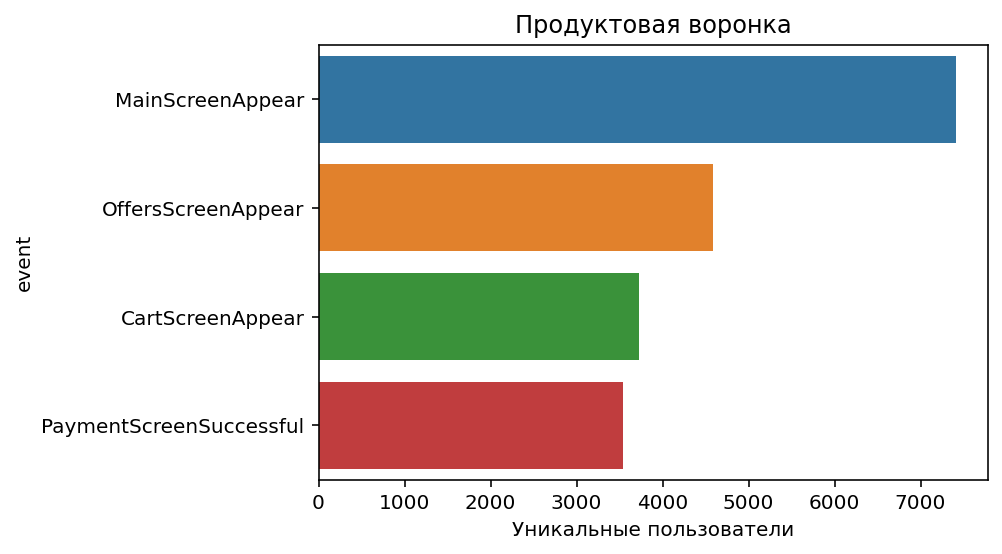

In [26]:
temp_1 = data_filtered.query('event != "Tutorial"') \
        .groupby('event').agg({'user_id':'nunique'}).sort_values('user_id', ascending=False) \
        .rename(columns={'user_id':'Уникальные пользователи'})

# общая конверсия
temp_2 = temp_1.apply(lambda x: x/temp_1.iloc[0,0]*100).rename(columns={'Уникальные пользователи':'Конверсия'})

# конверсия в шаг
# используем fill_value=temp_1.iloc[0,0], чтобы не получился NaN в первой строке
temp_2['Конверсия в шаг'] = temp_1['Уникальные пользователи'] \
                        .div(temp_1['Уникальные пользователи'].shift(periods=1,fill_value=temp_1.iloc[0,0])) * 100

result = pd.merge(temp_1, temp_2, left_index=True, right_index=True)
display(result)

sns.barplot(x='Уникальные пользователи', y=result.index, data=result)
plt.title('Продуктовая воронка')
plt.show()

**Вывод:** При переходе на шаг OffersScreenAppear теряется больше всего пользователей (39%). До оплаты доходит 47% пользователей, попавших на главную страницу.

## Анализ результатов A/B теста
<a id="fifth"></a>

Определим цель планируемого А/В-теста - повысить конверсию.

Метрика для отслеживания: конверсия.

Сформулируем гипотезы:
- Нулева гипотеза (Н0): изменение шрифта не повлияло на конверсию, конверсии групп А и В не отличаются, наблюдаемые различия случайны;<br>
- Альтернативная гипотеза (Н1): изменение шрифта повлияло на конверсию, конверсия группы В выше, чем А, и эти различия — результат изменений.<br>

In [27]:
# кол-во пользователей в каждой группе
# 246 и 247 — контрольные группы, а 248 — экспериментальная
data_filtered.groupby('group').agg({'user_id':'nunique'})

,user_id
group,
246,2482
247,2512
248,2536


In [28]:
2512/2482

1.0120870265914585

Количество пользователей в экспериментальны группах различается на 1%. Это говорит о неоптимальности разбиения данных по группам. Для будущих тестов следует несколько поработать с механикой выделения групп и, возможно, изменить подход к их выделению. В рамках текущей работы будем считать различие приемлемым.

Также проверим, что каждый пользователь состоит лишь в одной группе.

In [29]:
# группируем пользователей по кол-ву уникальных групп
temp = data_filtered.pivot_table(index='user_id', values='group', aggfunc='nunique') 
# смотрим значения по столбцу group
temp['group'].value_counts()

1    7530
Name: group, dtype: int64

Каждый из 7530 пользователей состоит лишь в одной группе.

In [30]:
# функция расчета конверсий по экспериментальным группам
# чтобы можно было считать по объединенным группам, параметр group передается списком
# доли считаем от общего числа уникальных пользователей
def get_conversion(group=[]):
    
    unique_users = data_filtered.query('group in @group')['user_id'].nunique()
    
    temp_1 = data_filtered.query('event != "Tutorial" and group in @group') \
        .groupby('event').agg({'user_id':'nunique'}).sort_values('user_id', ascending=False) \
        .rename(columns={'user_id':'Уникальные пользователи'})
    
    temp_2 = temp_1.apply(lambda x: x/unique_users * 100) \
    .rename(columns={'Уникальные пользователи':'Конверсия'})
    
    temp_2['Конверсия в шаг'] = temp_1['Уникальные пользователи'] \
                        .div(temp_1['Уникальные пользователи'].shift(periods=1,fill_value=temp_1.iloc[0,0])) * 100

    conversion = pd.merge(temp_1, temp_2, left_index=True, right_index=True)
    
    return conversion

In [31]:
# считаем конверсии по контрольным группам
display(get_conversion([246]))
display(get_conversion([247]))

,Уникальные пользователи,Конверсия,Конверсия в шаг
event,,,
MainScreenAppear,2448,98.630137,100.000000
OffersScreenAppear,1538,61.966156,62.826797
CartScreenAppear,1266,51.007252,82.314694
PaymentScreenSuccessful,1200,48.348106,94.786730


,Уникальные пользователи,Конверсия,Конверсия в шаг
event,,,
MainScreenAppear,2475,98.527070,100.000000
OffersScreenAppear,1518,60.429936,61.333333
CartScreenAppear,1237,49.243631,81.488801
PaymentScreenSuccessful,1157,46.058917,93.532741


Определим статистическую значимость различия в конверсиях для каждого события. Используем проверку гипотез о равенстве долей с помощью z-статистики.

Нулевая гипотеза (Н0): конверсии между группами не отличаются. <br>
Альтернативная гипотеза (H1): конверсии между группами отличаются.

In [32]:
# функция берет данные из get_conversion 
# и считает стат.значимость различий по событиям event
def get_stat_significance(event, group=[]):

    alpha = .05/4 # поправка Бонферрони (тестируется 4 нулевые гипотезы)
    
    # кол-во пользователей, дошедших до события в каждой группе
    successes = np.array([get_conversion(group[0]).loc[event, 'Уникальные пользователи'],
                          get_conversion(group[1]).loc[event, 'Уникальные пользователи']])
   
    # кол-во пользователей в каждой группе
    trials = np.array([data_filtered.query('group in @group[0]')['user_id'].nunique(), 
                       data_filtered.query('group in @group[1]')['user_id'].nunique()])

    # пропорция успехов в первой группе:
    p1 = successes[0]/trials[0]

    # пропорция успехов во второй группе:
    p2 = successes[1]/trials[1]

    # пропорция успехов в комбинированном датасете:
    p_combined = (successes[0] + successes[1]) / (trials[0] + trials[1])

    # разница пропорций в датасетах
    difference = p1 - p2

    # считаем z-статистику
    z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/trials[0] + 1/trials[1]))

    # задаем стандартное нормальное распределение (среднее 0, ст.отклонение 1)
    distr = stats.norm(0, 1) 

    p_value = (1 - distr.cdf(abs(z_value))) * 2

    print('p-значение: ', p_value)
    print(f'Относительная разница в конверсии между группам {group[1]} и {group[0]} = {p2/p1-1:.2%}')

    if p_value < alpha:
        print('Отвергаем нулевую гипотезу: между долями есть значимая разница')
    else:
        print(
        'Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными'
        )
        

In [33]:
get_stat_significance('PaymentScreenSuccessful', group=[[246],[247]])
get_stat_significance('CartScreenAppear', group=[[246],[247]])
get_stat_significance('OffersScreenAppear', group=[[246],[247]])
get_stat_significance('MainScreenAppear', group=[[246],[247]])

p-значение:  0.1051787680711449
Относительная разница в конверсии между группам [247] и [246] = -4.73%
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
p-значение:  0.21265373943905175
Относительная разница в конверсии между группам [247] и [246] = -3.46%
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
p-значение:  0.26533460123779884
Относительная разница в конверсии между группам [247] и [246] = -2.48%
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
p-значение:  0.7583738587337554
Относительная разница в конверсии между группам [247] и [246] = -0.10%
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


**Вывод:** Несмотря на то, что различия в конверсиях между контрольными группами существуют, они не являются статистически значимыми, можно считать их случайностью.<br>
Можно утверждать, что разбиение на группы работает корректно, конверсии не отличаются.

Далее посмотрим на конверсии в экспериментальной группе 248 с измененным шрифтом и проверим стат.значимость различий с каждой контрольной группой по отдельности.

Нулевая гипотеза (Н0): конверсии между группами не отличаются. <br>
Альтернативная гипотеза (H1): конверсии между группами отличаются.

In [34]:
display(get_conversion([246]))
display(get_conversion([247]))
display(get_conversion([248]))

,Уникальные пользователи,Конверсия,Конверсия в шаг
event,,,
MainScreenAppear,2448,98.630137,100.000000
OffersScreenAppear,1538,61.966156,62.826797
CartScreenAppear,1266,51.007252,82.314694
PaymentScreenSuccessful,1200,48.348106,94.786730


,Уникальные пользователи,Конверсия,Конверсия в шаг
event,,,
MainScreenAppear,2475,98.527070,100.000000
OffersScreenAppear,1518,60.429936,61.333333
CartScreenAppear,1237,49.243631,81.488801
PaymentScreenSuccessful,1157,46.058917,93.532741


,Уникальные пользователи,Конверсия,Конверсия в шаг
event,,,
MainScreenAppear,2492,98.264984,100.000000
OffersScreenAppear,1530,60.331230,61.396469
CartScreenAppear,1229,48.462145,80.326797
PaymentScreenSuccessful,1180,46.529968,96.013019


In [35]:
get_stat_significance('PaymentScreenSuccessful', group=[[246],[248]])
get_stat_significance('CartScreenAppear', group=[[246],[248]])
get_stat_significance('OffersScreenAppear', group=[[246],[248]])
get_stat_significance('MainScreenAppear', group=[[246],[248]])

p-значение:  0.19720322724507655
Относительная разница в конверсии между группам [248] и [246] = -3.76%
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
p-значение:  0.07141607238434666
Относительная разница в конверсии между группам [248] и [246] = -4.99%
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
p-значение:  0.2348576270284397
Относительная разница в конверсии между группам [248] и [246] = -2.64%
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
p-значение:  0.2958134972730775
Относительная разница в конверсии между группам [248] и [246] = -0.37%
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


In [36]:
get_stat_significance('PaymentScreenSuccessful', group=[[247],[248]])
get_stat_significance('CartScreenAppear', group=[[247],[248]])
get_stat_significance('OffersScreenAppear', group=[[247],[248]])
get_stat_significance('MainScreenAppear', group=[[247],[248]])

p-значение:  0.7371747299113722
Относительная разница в конверсии между группам [248] и [247] = 1.02%
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
p-значение:  0.5786346578606725
Относительная разница в конверсии между группам [248] и [247] = -1.59%
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
p-значение:  0.9428477337538643
Относительная разница в конверсии между группам [248] и [247] = -0.16%
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
p-значение:  0.4587142655517955
Относительная разница в конверсии между группам [248] и [247] = -0.27%
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


**Вывод:** Между экспериментальной и каждой контрольной группах нет статистически значимых различий.

Далее проверим стат.значимость различий с объединенной контрольной группой (246 + 247).

Нулевая гипотеза (Н0): конверсии между группами не отличаются. <br>
Альтернативная гипотеза (H1): конверсии между группами отличаются.

In [37]:
display(get_conversion([246,247])) # конверсия по объединенной контрольной группе
display(get_conversion([248]))

,Уникальные пользователи,Конверсия,Конверсия в шаг
event,,,
MainScreenAppear,4923,98.578294,100.00000
OffersScreenAppear,3056,61.193432,62.07597
CartScreenAppear,2503,50.120144,81.90445
PaymentScreenSuccessful,2357,47.196636,94.16700


,Уникальные пользователи,Конверсия,Конверсия в шаг
event,,,
MainScreenAppear,2492,98.264984,100.000000
OffersScreenAppear,1530,60.331230,61.396469
CartScreenAppear,1229,48.462145,80.326797
PaymentScreenSuccessful,1180,46.529968,96.013019


In [38]:
get_stat_significance('PaymentScreenSuccessful', group=[[246,247], [248]])
get_stat_significance('CartScreenAppear', group=[[246,247], [248]])
get_stat_significance('OffersScreenAppear', group=[[246,247], [248]])
get_stat_significance('MainScreenAppear', group=[[246,247], [248]])

p-значение:  0.5838149822499106
Относительная разница в конверсии между группам [248] и [246, 247] = -1.41%
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
p-значение:  0.1738364085481252
Относительная разница в конверсии между группам [248] и [246, 247] = -3.31%
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
p-значение:  0.46867588934617377
Относительная разница в конверсии между группам [248] и [246, 247] = -1.41%
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
p-значение:  0.2947448091724323
Относительная разница в конверсии между группам [248] и [246, 247] = -0.32%
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


**Вывод:** Различия между экспериментальной и объединенной контрольной группами также не являются статистически значимыми, можно считать их случайностью.

## Итоговый вывод
<a id="sixth"></a>

Изменение шрифтов в приложении не привело к увеличению конверсии ни в одном событии. Обнаруженные относительные различия в конверсиях не являются статистически значимымы, в связи с чем нельзя с уверенностью утверждать, какой шрифт лучше. Т.е. изменение шрифтов можно провести, однако это не увеличит показатели.

Уровень значимости выбран 5%, т.е. каждый 20-й раз можно получить ложный результат. Всего проведено 16 проверок статистических гипотез, уровень значимости выбран корректно.